In [49]:
from google.cloud import bigquery
import pandas as pd
#import pandas_gbp
import matplotlib.pyplot as plt
%matplotlib inline

def fetch_covid19_cases(table):
    # Construct a BigQuery client object.
    client = bigquery.Client()
    query = """
        SELECT *, 
        FROM `bigquery-public-data.covid19_jhu_csse.{0}`
    """.format(table)
    df_confirmed_cases = client.query(query).to_dataframe()
    df_confirmed_cases.drop(['latitude', 'longitude', 'location_geom'], axis=1, inplace=True)
    df_confirmed_cases['province_state'] = df_confirmed_cases['province_state'].fillna('ALL')
    df_confirmed_cases = df_confirmed_cases[df_confirmed_cases['province_state'] == 'ALL']
    df_confirmed_cases.rename(columns={'country_region': 'country'}, inplace=True)
    #df_confirmed_cases = df_confirmed_cases.set_index('country')
    df_confirmed_cases.drop(['province_state'], axis=1, inplace=True)
    return df_confirmed_cases

def fetch_population():
    client = bigquery.Client()
    query = """
        SELECT country_code, country_name as country, midyear_population as population FROM `bigquery-public-data.census_bureau_international.midyear_population`
        where year = EXTRACT(year from (CURRENT_DATE()))
        order by midyear_population desc
    """
    df_world_population = client.query(query).to_dataframe()
    df_world_population['country'][df_world_population['country'] == 'United States'] = 'US'
    df_world_population = df_world_population.set_index('country')
    return df_world_population

def covid_flip_datetocolumn(df_covid, col_name):
    dates = df_covid.columns[1:]
    df_temp = df_covid.melt(
        id_vars=['country'], 
        value_vars=dates,
        var_name='date', 
        value_name=col_name
    )
    df_temp['date']=df_temp['date'].map(lambda strtodate: strtodate.replace('_','/')[1:])
    return df_temp


In [2]:
df_confirmed = fetch_covid19_cases('confirmed_cases')
df_deaths = fetch_covid19_cases('deaths')
df_recovered = fetch_covid19_cases('recovered_cases')
df_world_population = fetch_population()

In [18]:
#remove canada as per https://towardsdatascience.com/covid-19-data-processing-58aaa3663f6
df_recovered = df_recovered[df_recovered['country']!='Canada']
df_covid = covid_flip_datetocolumn(df_confirmed, 'confirmed').merge(
    right=covid_flip_datetocolumn(df_deaths, 'deaths'), 
    how='left',
    on=['country', 'date']
).merge(
    right=covid_flip_datetocolumn(df_recovered, 'recovered'),
    how='left',
    on=['country', 'date']
)
ship_rows = df_covid['country'].str.contains('Diamond Princess') | df_covid['country'].str.contains('MS Zaandam')
df_covid = df_covid[~(ship_rows)]
df_covid['active'] = df_covid['confirmed'] - df_covid['deaths'] - df_covid['recovered']

In [53]:
df_covid_popl = df_covid.join(df_world_population, how='outer', on='country')
df_covid_popl[df_covid_popl['country']=='US']

,country,date,confirmed,deaths,recovered,active,country_code,population
179.0,US,1/22/20,1.0,0.0,0.0,1.0,US,334503458.0
364.0,US,1/23/20,1.0,0.0,0.0,1.0,US,334503458.0
549.0,US,1/24/20,2.0,0.0,0.0,2.0,US,334503458.0
734.0,US,1/25/20,2.0,0.0,0.0,2.0,US,334503458.0
919.0,US,1/26/20,5.0,0.0,0.0,5.0,US,334503458.0
...,...,...,...,...,...,...,...,...
23119.0,US,5/25/20,1662302.0,98219.0,379157.0,1184926.0,US,334503458.0
23304.0,US,5/26/20,1680913.0,98912.0,384902.0,1197099.0,US,334503458.0
23489.0,US,5/27/20,1699176.0,100417.0,391508.0,1207251.0,US,334503458.0
23674.0,US,5/28/20,1721753.0,101616.0,399991.0,1220146.0,US,334503458.0


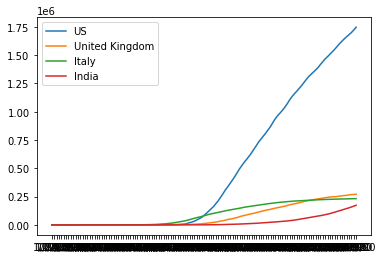

In [54]:
fig, ax = plt.subplots()
for country in ['US', 'United Kingdom', 'Italy', 'India']:
    ax.plot(df_covid_popl['date'][df_covid_popl['country'] == country], df_covid_popl['confirmed'][df_covid_popl['country'] == country], label=country)
ax.legend()
plt.show()

In [76]:
df_confirmed_cases_popl

,country,country_code,population,date,confirmed
0,Greece,GR,10742032.0,1/22/20,0.0
1,Togo,TO,8608444.0,1/22/20,0.0
2,Mozambique,MZ,28603070.0,1/22/20,0.0
3,Mali,ML,19553397.0,1/22/20,0.0
4,Eritrea,ER,6081196.0,1/22/20,0.0
...,...,...,...,...,...
30568,Cook Islands,CW,8574.0,5/29/20,NaN
30569,"Saint Helena, Ascension, and Tristan da Cunha",SH,7862.0,5/29/20,NaN
30570,Saint Barthelemy,TB,7122.0,5/29/20,NaN
30571,Montserrat,MH,5373.0,5/29/20,NaN
